In [24]:
try: 
    # This library is our indicator that the required installs
    # need to be done.
    import datasets
    root_path = '.'
except ModuleNotFoundError:
    !git clone https://github.com/cgpotts/cs224u/
    !pip install -r cs224u/requirements.txt
    root_path = 'dsp'

In [25]:
import pandas as pd 
import cohere
from datasets import load_dataset
import openai
import re
import os
import dsp
import transformers

In [105]:
# Read the contents of the file
with open('/Users/kerriewu/cs224u/Climate-LLMs/keys.txt', 'r') as file:
    file_contents = file.read()

# Assign the variables
exec(file_contents)

os.environ["DSP_NOTEBOOK_CACHEDIR"] = os.path.join(root_path, 'cache')
openai_key = OPENAI_API_KEY  
cohere_key = COHERE_API_KEY  

In [106]:
[d["root"] for d in openai.Model.list(api_key=openai_key)["data"]]

['whisper-1',
 'babbage',
 'davinci',
 'text-davinci-edit-001',
 'babbage-code-search-code',
 'text-similarity-babbage-001',
 'code-davinci-edit-001',
 'text-davinci-001',
 'ada',
 'babbage-code-search-text',
 'babbage-similarity',
 'code-search-babbage-text-001',
 'text-curie-001',
 'code-search-babbage-code-001',
 'text-embedding-ada-002',
 'text-ada-001',
 'text-similarity-ada-001',
 'curie-instruct-beta',
 'ada-code-search-code',
 'ada-similarity',
 'code-search-ada-text-001',
 'text-search-ada-query-001',
 'davinci-search-document',
 'ada-code-search-text',
 'text-search-ada-doc-001',
 'davinci-instruct-beta',
 'text-similarity-curie-001',
 'code-search-ada-code-001',
 'ada-search-query',
 'text-search-davinci-query-001',
 'curie-search-query',
 'davinci-search-query',
 'babbage-search-document',
 'ada-search-document',
 'text-search-curie-query-001',
 'text-search-babbage-doc-001',
 'curie-search-document',
 'text-search-curie-doc-001',
 'babbage-search-query',
 'text-babbage-001

In [107]:
## We use the chatGPT AR-LM model

# lm = dsp.GPT3(model = "gpt-4", api_key=openai_key, model_type="chat")
# lm = dsp.GPT3(model = "gpt-4", api_key=openai_key, model_type="chat")
lm = dsp.Cohere(model = "command-xlarge-nightly", api_key=cohere_key)
dsp.settings.configure(lm=lm)
dsp.settings.show_guidelines = True

In [108]:
dataset = pd.read_csv('./data/random_baseline.csv')

dataset.tail

<bound method NDFrame.tail of                                                  input  source
0                                 Paula burned a girl.  recogs
1     A boy hoped that Liam hoped that the hippo drew.  recogs
2                           A chicken wanted to crawl.  recogs
3     The duck on a boat was given a cake in the room.  recogs
4                       Charlotte served a girl Paula.  recogs
..                                                 ...     ...
332  Covering beats as diverse as Crestline city go...   onion
333  Devastated by the dot-com collapse, Silicon Va...   onion
334  Members of the national media watchdog group F...   onion
335  In an effort to put the man’s behavior into co...   onion
336  In an effort to address mounting pressure from...   onion

[337 rows x 2 columns]>

In [109]:
random_sent = [dsp.Example(input=row['input'], source = row['source'])
                    for _, row in dataset.iterrows()]

In [110]:
random_sent[:10]

[{'input': 'Paula burned a girl.', 'source': 'recogs'},
 {'input': 'A boy hoped that Liam hoped that the hippo drew.',
  'source': 'recogs'},
 {'input': 'A chicken wanted to crawl.', 'source': 'recogs'},
 {'input': 'The duck on a boat was given a cake in the room.',
  'source': 'recogs'},
 {'input': 'Charlotte served a girl Paula.', 'source': 'recogs'},
 {'input': 'A girl returned Lina to a teacher.', 'source': 'recogs'},
 {'input': 'The baby proved that Mason squeezed a ball beside the key.',
  'source': 'recogs'},
 {'input': 'The girl sketched Paula.', 'source': 'recogs'},
 {'input': 'Emma shattered the cake in a house.', 'source': 'recogs'},
 {'input': 'The professor liked Lina.', 'source': 'recogs'}]

In [111]:
print(len(random_sent))
print(len([ex for ex in random_sent if ex.source=='recogs']))
print(len([ex for ex in random_sent if ex.source=='feverclaim']))
print(len([ex for ex in random_sent if ex.source=='feverrefuted']))
print(len([ex for ex in random_sent if ex.source=='onion']))
print(len([ex for ex in random_sent if ex.source not in ['recogs', 'feverclaim', 'feverrefuted', 'onion']]))
print([sentence for sentence in random_sent if sentence.source not in ['recogs', 'feverclaim', 'feverrefuted', 'onion']] )


337
100
100
100
37
0
[]


In [112]:
Input = dsp.Type(
    prefix="Statement:", 
    desc="${a short statement about climate.}")

Label = dsp.Type(
    prefix="Confidence:", 
    desc="${must be *only*: 'low', 'medium', 'high', 'very high'}")

zero_shot_template = dsp.Template(
    instructions="You are a knowledgeable assistant trained to assess the confidence level associated with various statements. \
      \n\nYou will be presented with a statement. Humans have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?  \
      \n\nRespond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.",
    input=Input(),
    output=Label())

In [113]:
ex = dsp.Example(
    input=random_sent[0]['input'], label='')

ex.demos=dsp.sample(random_sent, 0)

print(zero_shot_template(ex))

You are a knowledgeable assistant trained to assess the confidence level associated with various statements.       

You will be presented with a statement. Humans have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Paula burned a girl.
Confidence:


In [114]:
@dsp.transformation
def assess_certainty(example, temperature=0.7): 
    
    example, completion = dsp.generate(zero_shot_template,  temperature=temperature)(example, stage='zero-shot')

    return completion

def extract_confidence(text):
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

In [115]:
assess_certainty(ex).label

''

In [116]:
lm.inspect_history(n=1)





You are a knowledgeable assistant trained to assess the confidence level associated with various statements.       

You will be presented with a statement. Humans have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Paula burned a girl.
Confidence: high





# First experiment

We assess the certainty level of the LM on the dataset, filter the output for extra "confidence" etc., then analyze the average confidence of the model based on the input source. 

In [117]:
samples = dataset.copy()  # Dev: train_set.sample(n=100, random_state=12).copy() | Experiment: test_set.copy()

samples.head

<bound method NDFrame.head of                                                  input  source
0                                 Paula burned a girl.  recogs
1     A boy hoped that Liam hoped that the hippo drew.  recogs
2                           A chicken wanted to crawl.  recogs
3     The duck on a boat was given a cake in the room.  recogs
4                       Charlotte served a girl Paula.  recogs
..                                                 ...     ...
332  Covering beats as diverse as Crestline city go...   onion
333  Devastated by the dot-com collapse, Silicon Va...   onion
334  Members of the national media watchdog group F...   onion
335  In an effort to put the man’s behavior into co...   onion
336  In an effort to address mounting pressure from...   onion

[337 rows x 2 columns]>

In [118]:
samples['prediction'] = samples.input.apply(
    lambda x: extract_confidence(assess_certainty(dsp.Example(input=x, demos=dsp.sample(random_sent, 0)), temperature=0).output.lower()))

In [119]:
lm.inspect_history(n=1)





You are a knowledgeable assistant trained to assess the confidence level associated with various statements.       

You will be presented with a statement. Humans have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: In an effort to address mounting pressure from environmental advocates, cryptocurrency executives attempted to address criticism over the massive carbon footprint of their technology by unveiling a digital avatar of a glacier.
Confidence: high





In [120]:
samples.head(5)

,input,source,prediction
0,Paula burned a girl.,recogs,high
1,A boy hoped that Liam hoped that the hippo drew.,recogs,high
2,A chicken wanted to crawl.,recogs,very high
3,The duck on a boat was given a cake in the room.,recogs,high
4,Charlotte served a girl Paula.,recogs,high


In [121]:
samples.to_csv('./results/cohere-command-xlarge-nightly-zeroshot-temp0-2023-06-08-randombaseline.csv')

In [125]:
recogs = samples[samples.source=='recogs']
fever_true = samples[samples.source=='feverclaim']
fever_false = samples[samples.source=='feverrefuted']
onion = samples[samples.source=='onion']

In [126]:
# breakdown each source by number of predicted low, medium, high, very high
print('##########Recogs prediction distribution count###############')
print(recogs.prediction.value_counts())
print('##########Fever True Statements prediction distribution count###############')
print(fever_true.prediction.value_counts())
print('##########Fever False Statements prediction distribution count###############')
print(fever_false.prediction.value_counts())
print('##########Onion prediction distribution count###############')
print(onion.prediction.value_counts())

##########Recogs prediction distribution count###############
prediction
high         83
very high    16
idk           1
Name: count, dtype: int64
##########Fever True Statements prediction distribution count###############
prediction
high         93
very high     6
low           1
Name: count, dtype: int64
##########Fever False Statements prediction distribution count###############
prediction
high         73
low          15
very high    11
idk           1
Name: count, dtype: int64
##########Onion prediction distribution count###############
prediction
high         31
very high     4
low           2
Name: count, dtype: int64


In [129]:
filtered_samples = samples.loc[(samples['prediction'] != 'N/A')] # & (samples['report'] != 'AR6_WGI')]

value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3, 'idk': 1.5}

filtered_samples['predicted_score'] = filtered_samples.prediction.apply(
    lambda x: value_map[x])

scores_all = {
    "recogs": filtered_samples.loc[samples['source'] == 'recogs', 'predicted_score'].mean(),
    "fever_true": filtered_samples.loc[samples['source'] == 'feverclaim', 'predicted_score'].mean(),
    "fever_false": filtered_samples.loc[samples['source'] =='feverrefuted', 'predicted_score'].mean(),
    "onion": filtered_samples.loc[samples['source'] == 'onion', 'predicted_score'].mean()
}


In [130]:
print(scores_all)

{'recogs': 2.155, 'fever_true': 2.04, 'fever_false': 1.805, 'onion': 2.0}


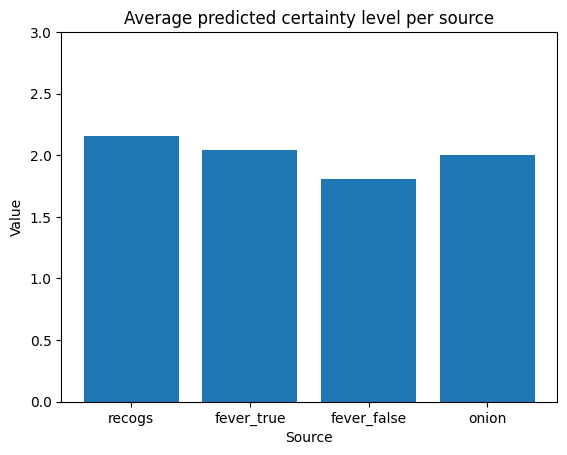

In [131]:
import matplotlib.pyplot as plt
keys = []
values = []
for k, v in scores_all.items():
    keys.append(k)
    values.append(v)

fig = plt.figure()
plt.bar(keys, values)
# Set the y-axis limits
plt.ylim(0, 3)

plt.title('Average predicted certainty level per source')
plt.xlabel('Source')
plt.ylabel('Value')
plt.show()

In [132]:
fig.savefig('./results/cohere-command-xlarge-nightly-zeroshot-temp0-20230608_randombaseline_avg_mean_certainty')